# Scene swap: Repeated Surveys over Several Scene States

Notebook: Hannah Weiser, 2024

This notebook demonstrates how to use the [scene swap feature]() in HELIOS++ both for a terrestrial laser scanning (TLS) and UAV-based laser scanning (ULS) example.
In the HELIOS++ scene XML, swaps can be defined for each scene part, resulting in a sequence of different scene states. HELIOS++ will automatically repeat the survey for each scene state.

We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.

In [1]:
from pathlib import Path
from IPython.display import Code
from pyhelios.util.xmldisplayer import display_xml, find_playback_dir
import laspy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import os
os.chdir("..")

# TLS 

## Survey

The survey consists of two flight lines from a height of 400 m, placed 200 m apart. The scanner is a Leica ALS-50.

In [3]:
Code(display_xml('./data/surveys/dyn/als_dyn_geom_swap.xml'), language='XML')

<document>
    <survey name="dyn_geom_swap_als" scene="data/scenes/dyn/dyn_geom_swap_scene.xml#dyn_geom_swap_scene" platform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#leica_als50">
		<leg>
            <platformSettings x="100" y="100.0" z="400" onGround="false" movePerSec_m="5" />
            <scannerSettings active="true" pulseFreq_hz="83000" scanFreq_hz="70" scanAngle_deg="60" trajectoryTimeInterval_s="0.01" />
        </leg>
		<leg>
            <platformSettings x="-100" y="-100.0" z="400" onGround="false" movePerSec_m="5" />
            <scannerSettings active="false" pulseFreq_hz="83000" scanFreq_hz="70" scanAngle_deg="60" />
        </leg>
		<leg>
            <platformSettings x="-100" y="100.0" z="400" onGround="false" movePerSec_m="5" />
            <scannerSettings active="true" pulseFreq_hz="83000" scanFreq_hz="70" scanAngle_deg="60" trajectoryTimeInterval_s="0.01" />
        </leg>
		<leg>
            <platformSettings x="100" y="-100.0" z="400" onGround="false" movePerSec_m="5" />
            <scannerSettings active="false" pulseFreq_hz="83000" scanFreq_hz="70" scanAngle_deg="60" />
        </leg>
    </survey>
</document>

## Scene

The scene consists of three scene parts and has a total of four swaps.
Based on the definition, the output of the loops will be as follows:

**Loop 1**:
1. small cube
2. sphere
3. small cube 2

**Loop 2**:
1. sphere
2. big cube
3. mid cube

**Loop 3**:
1. sphere
2. nothing
3. big cube

**Loop 4**:
1. big cube
2. nothing
3. bigger cube



In [4]:
Code(display_xml('data/scenes/dyn/dyn_geom_swap_scene.xml', 'dyn_geom_swap_scene'))

<scene id="dyn_geom_swap_scene" name="DynGeomSwapScene">


		<!-- Ground plane -->
		<!-- ************ -->
		<part id="1">
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/basic/groundplane/groundplane.obj" />
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="120" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="50.0;0;0" />
			</filter>
        </part>




		<!-- Small cube goes sphere for two repetitions then goes big cube -->
		<!-- ************************************************************* -->
		<part id="2">
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="rotate">
				<param key="rotation" type="rotation">
					<rot angle_deg="45" axis="z" />
				</param>
			</filter>
			<filter type="scale">
                <param type="double" key="scale" value="0.75" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="-40.0;-50.0;0" />
			</filter>
			<!-- Swap small cube by sphere -->
			<swap swapStep="2">
				<filter type="objloader">
                	<param type="string" key="filepath" value="data/sceneparts/toyblocks/sphere.obj" />
		        </filter>
				<filter type="scale">
		            <param type="double" key="scale" value="1.25" />
		        </filter>
				<filter type="translate">
					<param type="vec3" key="offset" value="-30.0;-60.0;0" />
				</filter>
			</swap>
			<!-- Swap sphere by big cube -->
			<swap swapStep="1">
				<filter type="objloader">
		            <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
		        </filter>
				<filter type="rotate">
					<param key="rotation" type="rotation">
						<rot angle_deg="45" axis="z" />
					</param>
				</filter>
				<filter type="scale">
		            <param type="double" key="scale" value="1.5" />
		        </filter>
				<filter type="translate">
					<param type="vec3" key="offset" value="-20.0;-60.0;0" />
				</filter>
			</swap>
        </part>




		<!-- Sphere goes cube goes nothing -->
		<!-- ***************************** -->
		<part id="3">
			<filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/sphere.obj" />
            </filter>
			<filter type="scale">
                <param type="double" key="scale" value="1.25" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="-10.0;-20.0;0" />
			</filter>
			<!-- Swap sphere by cube -->
			<swap>
				<filter type="objloader">
		            <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
		        </filter>
				<filter type="scale">
		            <param type="double" key="scale" value="2.0" />
		        </filter>
				<filter type="translate">
					<param type="vec3" key="offset" value="-40.0;40.0;0" />
				</filter>
			</swap>
			<!-- Swap cube by nothing -->
			<swap force_null="true">
			</swap>
		</part>




		<!-- Small cube goes mid goes big goes bigger -->
		<!-- **************************************** -->
		<part id="4">
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="rotate">
				<param key="rotation" type="rotation">
					<rot angle_deg="45" axis="z" />
				</param>
			</filter>
			<filter type="scale">
                <param type="double" key="scale" value="0.75" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="-20.0;10.0;0" />
			</filter>
			<!-- Swap small cube by mid cube -->
			<swap swapStep="1">
				<filter type="rotate">
					<param key="rotation" type="rotation">
						<rot angle_deg="45" axis="z" />
					</param>
		

## Executing the Simulation

To run the simulation in Jupyter Notebooks, we can use the `!command` syntax, but you can also just run it from the command line.
To get the output as a "laz" file, we also specify `--lasOutput` and `--zipOutput`. We also set the `--rebuildScene` flag, because HELIOS++ rewrites the binary `.scene` file for each swap iteration. If we had run the survey before and did had set this flag, HELIOS++ would just use the existing scene file and perform only one simulation (the last one from the previous run).

In [5]:
!helios data/surveys/dyn/als_dyn_geom_swap.xml --lasOutput --zipOutput --rebuildScene

HELIOS++ VERSION 2.0.0a4.dev35+g6054b703

CWD: "d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios"
seed: AUTO
surveyPath: "data/surveys/dyn/als_dyn_geom_swap.xml"
assetsPath: ["d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios", "D:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\python\pyhelios", "D:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\python\pyhelios\data", "assets/", ]
outputPath: "output/"
writeWaveform: 0
writePulse: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 1
writeScene: 1
lasOutput: 1
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: als_dyn_geom_swap.xml
xmlDocFilePath: d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\data/surveys/dyn
xmlDocFilename: scanners_als.xml
xmlDocFilePath: D:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\python\pyhelios\data


## The results

Now let's find the output files, load it, and visualize it.
Since we performed several simulations, we have several output folders, four in total.

In [6]:
# get the last four folders that were written for this survey
output_path = find_playback_dir(r"data/surveys/dyn/als_dyn_geom_swap.xml")
folders_sorted = sorted(Path(output_path).parent.glob('*'))[-4:]

In [7]:
def read_pc(path, pt_src_id):
    las = laspy.read(path)
    pc = np.array([las.x, las.y, las.z]).T
    object_id = las['hitObjectId']
    pt_src_id = np.repeat(pt_src_id, pc.shape[0])

    return pc, object_id, pt_src_id

def load_and_merge(pc_folder):
    print('Loading points from', Path(pc_folder))

    pcs = []
    obj_ids = []
    pt_src_ids = []

    for i, file in enumerate(Path(pc_folder).glob('*.laz')):
        pc, object_id, pt_src_id = read_pc(file, pt_src_id=i)
        pcs.append(pc)
        obj_ids.append(object_id)
        pt_src_ids.append(pt_src_id)
        
    print('Merging files')
    try:
        pc_merged = np.vstack(pcs)
        object_id_merged = np.hstack(obj_ids)
        pt_src_id_merged = np.hstack((pt_src_ids))
    except ValueError:
        print('No points found in folder')
        pc_merged = np.array([])
        object_id_merged = np.array([])
        pt_src_id_merged = np.array([])

    return pc_merged, object_id_merged, pt_src_id_merged

In [8]:
sim_dict = {'name': [],
            'pcs': [],
            'object_ids': [],
            'pt_src_ids': []}
for i, folder in enumerate(folders_sorted):
    pc, obj_id, pt_src_id = load_and_merge(folder)
    sim_dict['name'].append(folder.name)
    sim_dict['pcs'].append(pc)
    sim_dict['object_ids'].append(obj_id)
    sim_dict['pt_src_ids'].append(pt_src_id)

Loading points from d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\output\dyn_geom_swap_als\2024-11-08_16-57-31
Merging files
Loading points from d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\output\dyn_geom_swap_als\2024-11-08_16-57-42
Merging files
Loading points from d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\output\dyn_geom_swap_als\2024-11-08_16-57-53
Merging files
Loading points from d:\daten\HELIOS\DEBUG\HELIOS_alpha-dev_202410\helios\output\dyn_geom_swap_als\2024-11-08_16-58-04
Merging files


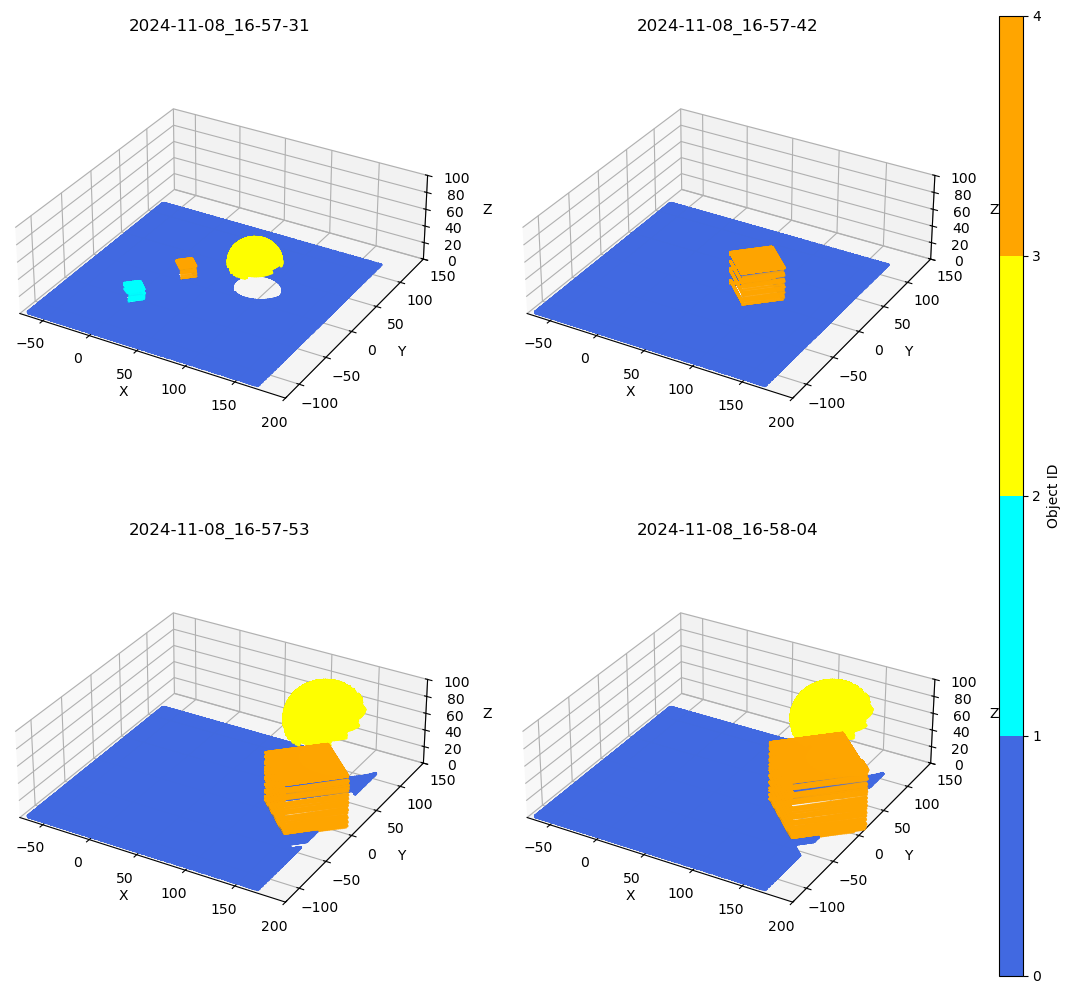

In [11]:
# create figure with 4 panels and 3d axes
fig = plt.figure(figsize=(12, 12))
last_pc = sim_dict['pcs'][-1]
box = (np.ptp(last_pc[:, 0]), np.ptp(last_pc[:, 1]), np.ptp(last_pc[:, 2]))

cmap = (mpl.colors.ListedColormap(['royalblue', 'cyan', 'yellow', 'orange']))
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i, (pc, obj_id, name) in enumerate(zip(sim_dict['pcs'], sim_dict['object_ids'], sim_dict['name'])):
    if pc.size == 0:
        continue
    # plot points in 3D with color based on object id in the respecitve panel
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=obj_id, cmap=cmap, s=1)
    # set equal axes
    ax.set_box_aspect(box)
    # set limits and labels
    ax.set_xlim(-75, 200)
    ax.set_xlabel('X')
    ax.set_ylim(-125, 150)
    ax.set_ylabel('Y')
    ax.set_zlim(0, 100)
    ax.set_zlabel('Z')
    ax.set_title(name)

ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='vertical',
             label="Object ID")
plt.show()

Output is actually not as expected...